In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
import tflearning
from tflearning.sample_difficulty.el2n_grand_scores import El2nAndGrandScores
from tflearning.sample_difficulty.plot import plot_pruning_results_fixed_samples, plot_pruning_results

# 32 CIFAR10 scratch with pruned dataset

Train a resnet18 on cifar 10 from scratch in order to compute in-distribution Prediction depth entropies.

## A. Resnet20 (fix sample size)

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 3
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.6, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.restrict_n_samples
    vals: [1000, 5000, 10000]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
  - parameter: data.sample_selector.kwargs.pruning_metric
    vals: [el2n, grand]

    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '32-cf10-scratch-pruned'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet20-scratch-pruned-dataset
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  
  model:
    model_cfg: resnet20-cifar10-B
  
  trainer:
    training_setup: finetune
    n_epochs: 200
    save_every: 200
    val_every: 1
    early_stopping_patience: 200
    batch_size: 128
    optimizer:
      name: SGD
      kwargs:
        lr: 0.1
        weight_decay: 0.0005
        momentum: 0.9
    lr_scheduler: 
      name: MultiStepLR
      kwargs:
        milestones: [60, 120, 160]
        gamma: 0.2
    loss: crossentropy
    num_workers: 4
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data #/local00/bioinf/beck/data #
      n_px: 32
    sample_selector:
      name: pruningmetric_class_balance
      kwargs:
        fraction: 0.1
        pruning_metric_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs/cifar10-30-cf10-el2n.1-resnet18--230322_095821/el2n_grand_scores_230323_091752.p
        pruning_metric: grand #el2n
        keep_highest: True
        restrict_n_samples: 1000
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [4]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 32-cf10-scratch-pruned(1)
Exp. Name: cifar10-32-cf10-scratch-pruned.1-resnet20-scratch-pruned-dataset
Training setup: finetune
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.restrict_n_samples: [1000, 5000, 10000]
  data.sample_selector.kwargs.keep_highest: [True, False]
  data.sample_selector.kwargs.pruning_metric: ['el2n', 'grand']
Seeds: [0]
Num. jobs: 60
Config updated: 2023-03-23 14:30:28
Sweep started:  2023-03-23 14:28:50



In [10]:
ft_epoch = 200
ft_col_sel = 'Accuracy-top-1'
ft_row_sel = ('epoch', ft_epoch)
col_name = f'{ft_col_sel}-{ft_row_sel[0]}-{ft_row_sel[1]}'
df = sweepr.get_summary(log_source='val', col_sel=ft_col_sel, row_sel=ft_row_sel)


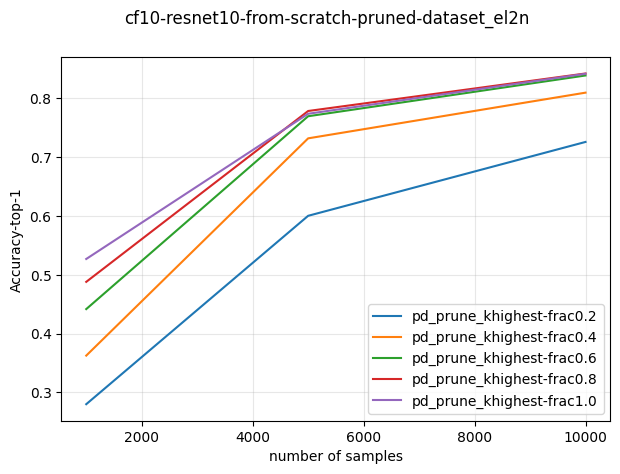

In [19]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                                       pd_pruning_results=sweepr,
                                       ft_epoch=200,
                                       ft_col_sel='Accuracy-top-1',
                                       title='cf10-resnet10-from-scratch-pruned-dataset', keep_highest=True, pruning_metric='el2n')

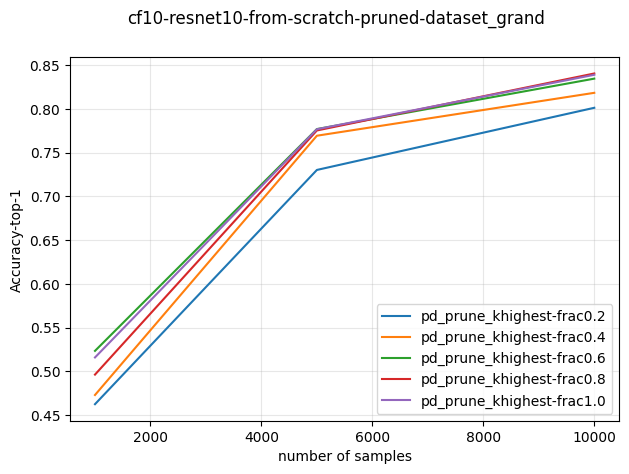

In [20]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                                       pd_pruning_results=sweepr,
                                       ft_epoch=200,
                                       ft_col_sel='Accuracy-top-1',
                                       title='cf10-resnet10-from-scratch-pruned-dataset', keep_highest=True, pruning_metric='grand')

**COMMENT**: Compare to Figure 1 (Deep learning on a Data Diet). 

## A. Resnet20 (vary sample size) el2n, grand

### Config file

In [4]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [1,2,3]
  runs_per_gpu: 3
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  # - parameter: data.sample_selector.kwargs.restrict_n_samples
  #   vals: [1000, 5000, 10000]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
  - parameter: data.sample_selector.kwargs.pruning_metric
    vals: [el2n, grand]
  - parameter: data.sample_selector.name
    vals: [pruningmetric_class_balance, pruningmetric]

start_num: 2

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '32-cf10-scratch-pruned'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-rn20
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  
  model:
    model_cfg: resnet20-cifar10-B
  
  trainer:
    training_setup: finetune
    n_epochs: 200
    save_every: 200
    val_every: 1
    early_stopping_patience: 200
    batch_size: 128
    optimizer:
      name: SGD
      kwargs:
        lr: 0.1
        weight_decay: 0.0005
        momentum: 0.9
    lr_scheduler: 
      name: MultiStepLR
      kwargs:
        milestones: [60, 120, 160]
        gamma: 0.2
    loss: crossentropy
    num_workers: 4
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data #/local00/bioinf/beck/data #
      n_px: 32
    sample_selector:
      name: pruningmetric_class_balance
      kwargs:
        fraction: 0.1
        pruning_metric_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs/cifar10-30-cf10-el2n.1-resnet18--230322_095821/el2n_grand_scores_230323_091752.p
        pruning_metric: grand #el2n
        keep_highest: True
        restrict_n_samples: -1
"""
cfg = OmegaConf.create(config_yaml)

In [25]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [5]:
sweepr_el2n_grand = REPO.get_output_loader(cfg)
print(sweepr_el2n_grand)

Exp. Tag(start_num): 32-cf10-scratch-pruned(2)
Exp. Name: cifar10-32-cf10-scratch-pruned.2-rn20
Training setup: finetune
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.keep_highest: [True, False]
  data.sample_selector.kwargs.pruning_metric: ['el2n', 'grand']
  data.sample_selector.name: ['pruningmetric_class_balance', 'pruningmetric']
Seeds: [0]
Num. jobs: 48
Config updated: 2023-03-23 16:51:48
Sweep started:  2023-03-23 16:49:59



## A. Resnet20 (vary sample size) random

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [0]
  runs_per_gpu: 3
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  # - parameter: data.sample_selector.kwargs.restrict_n_samples
  #   vals: [1000, 5000, 10000]
  # - parameter: data.sample_selector.kwargs.keep_highest
  #   vals: [True, False]
  # - parameter: data.sample_selector.kwargs.pruning_metric
  #   vals: [el2n, grand]
  - parameter: data.sample_selector.name
    vals: [random]

start_num: 3

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '32-cf10-scratch-pruned'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-rn20
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  
  model:
    model_cfg: resnet20-cifar10-B
  
  trainer:
    training_setup: finetune
    n_epochs: 200
    save_every: 200
    val_every: 1
    early_stopping_patience: 200
    batch_size: 128
    optimizer:
      name: SGD
      kwargs:
        lr: 0.1
        weight_decay: 0.0005
        momentum: 0.9
    lr_scheduler: 
      name: MultiStepLR
      kwargs:
        milestones: [60, 120, 160]
        gamma: 0.2
    loss: crossentropy
    num_workers: 4
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data #/local00/bioinf/beck/data #
      n_px: 32
    sample_selector:
      name: random
      kwargs:
        fraction: 0.1
        restrict_n_samples: -1
"""
cfg = OmegaConf.create(config_yaml)

In [7]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [3]:
sweepr_rand = REPO.get_output_loader(cfg)
print(sweepr_rand)

Exp. Tag(start_num): 32-cf10-scratch-pruned(3)
Exp. Name: cifar10-32-cf10-scratch-pruned.3-rn20
Training setup: finetune
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  data.sample_selector.name: ['random']
Seeds: [0]
Num. jobs: 6
Config updated: 2023-03-23 16:53:48
Sweep started:  2023-03-23 16:52:06



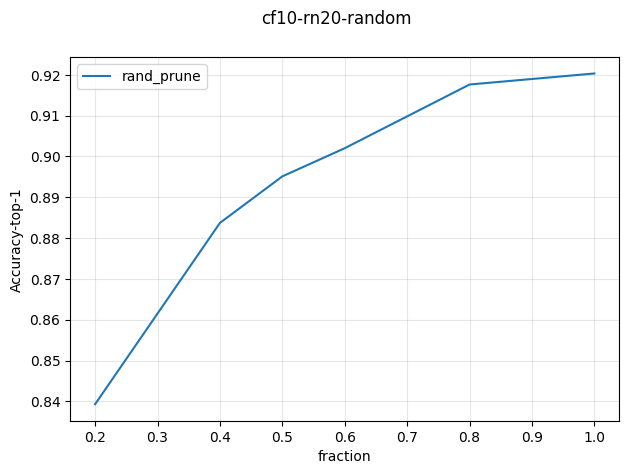

In [14]:
f = plot_pruning_results(random_pruning_results=sweepr_rand, pd_pruning_results=None, ft_epoch=200, ft_col_sel='Accuracy-top-1', title='cf10-rn20-random')

## A. Resnet20 (vary sample size) pred_depth_entropy

### Config file

In [20]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: ocelot
  gpu_ids: [0]
  runs_per_gpu: 3
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  # - parameter: data.sample_selector.kwargs.restrict_n_samples
  #   vals: [1000, 5000, 10000]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
  - parameter: data.sample_selector.kwargs.pruning_metric
    vals: [prediction_depth]
  - parameter: data.sample_selector.name
    vals: [pruningmetric_class_balance, pruningmetric]

start_num: 4pd

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '32-cf10-scratch-pruned'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-rn20
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  
  model:
    model_cfg: resnet20-cifar10-B
  
  trainer:
    training_setup: finetune
    n_epochs: 200
    save_every: 200
    val_every: 1
    early_stopping_patience: 200
    batch_size: 128
    optimizer:
      name: SGD
      kwargs:
        lr: 0.1
        weight_decay: 0.0005
        momentum: 0.9
    lr_scheduler: 
      name: MultiStepLR
      kwargs:
        milestones: [60, 120, 160]
        gamma: 0.2
    loss: crossentropy
    num_workers: 4
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data #/local00/bioinf/beck/data #
      n_px: 32
    sample_selector:
      name: pruningmetric_class_balance
      kwargs:
        fraction: 0.1
        pruning_metric_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10-resnet20-knnsamples1000-knnneighs30-seed1--230323_140338/prediction_depth_results.p
        pruning_metric: prediction_depth
        keep_highest: True
        restrict_n_samples: -1
"""
cfg = OmegaConf.create(config_yaml)

In [17]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [22]:
sweepr_pd = REPO.get_output_loader(cfg)
print(sweepr_pd)

Exp. Tag(start_num): 32-cf10-scratch-pruned(4pd)
Exp. Name: cifar10-32-cf10-scratch-pruned.4pd-rn20
Training setup: finetune
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.keep_highest: [True, False]
  data.sample_selector.kwargs.pruning_metric: ['prediction_depth']
  data.sample_selector.name: ['pruningmetric_class_balance', 'pruningmetric']
Seeds: [0]
Num. jobs: 24
Config updated: 2023-03-23 17:06:59
Sweep started:  2023-03-23 17:12:28



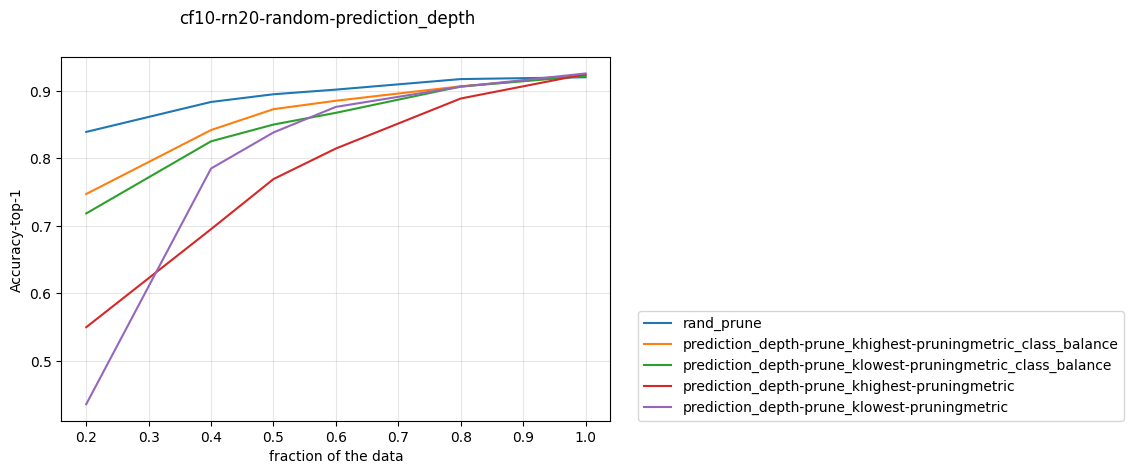

In [52]:
f = plot_pruning_results(random_pruning_results=sweepr_rand,
                         metric_pruning_results=sweepr_pd,
                         ft_epoch=200,
                         ft_col_sel='Accuracy-top-1',
                         title='cf10-rn20-random-prediction_depth', 
                         pruning_metric_name=['prediction_depth'], 
                         save_format='png')


In [6]:
print(sweepr_el2n_grand)

Exp. Tag(start_num): 32-cf10-scratch-pruned(2)
Exp. Name: cifar10-32-cf10-scratch-pruned.2-rn20
Training setup: finetune
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.keep_highest: [True, False]
  data.sample_selector.kwargs.pruning_metric: ['el2n', 'grand']
  data.sample_selector.name: ['pruningmetric_class_balance', 'pruningmetric']
Seeds: [0]
Num. jobs: 48
Config updated: 2023-03-23 16:51:48
Sweep started:  2023-03-23 16:49:59



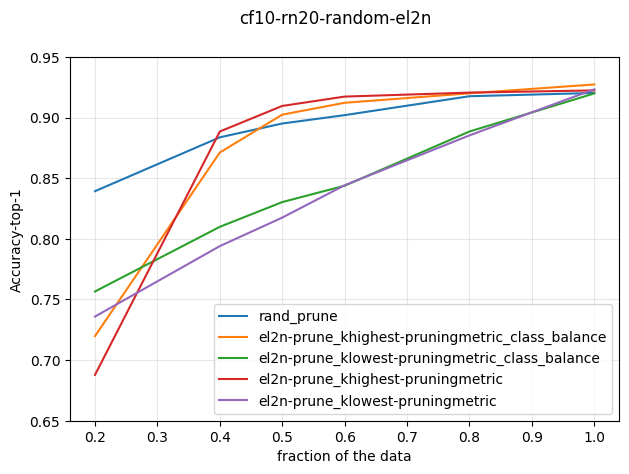

In [15]:
f = plot_pruning_results(random_pruning_results=sweepr_rand,
                         metric_pruning_results=sweepr_el2n_grand,
                         ft_epoch=200,
                         ft_col_sel='Accuracy-top-1',
                         title='cf10-rn20-random-el2n',
                         pruning_metric_name=['el2n'], 
                         y_lim=[0.65, 0.95],
                         save_format='png')

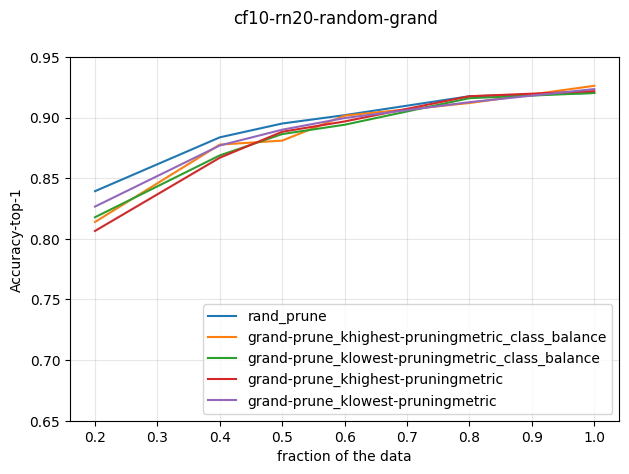

In [16]:
f = plot_pruning_results(random_pruning_results=sweepr_rand,
                         metric_pruning_results=sweepr_el2n_grand,
                         ft_epoch=200,
                         ft_col_sel='Accuracy-top-1',
                         title='cf10-rn20-random-grand', 
                         pruning_metric_name=['grand'], 
                         y_lim=[0.65, 0.95],
                         save_format='png')